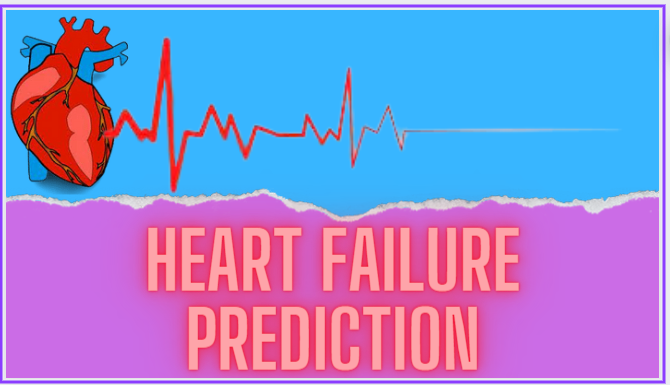

In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 # **<span style="color:steelblue">TABLE OF CONTENTS</span>**
 

**Importing Libraries**

**Loading Data**

**Separating Independent and Dependent Features**

**Split Features Into Numerical and Categorical**

**EDA**

**Feature Selection**

**Feature Engineering**

**MODEL BUILDING**

**Logistic Regression**

**SVC**

**Decision Tree**

**Random Forest**

**Naive Bayes**

**KNN**

**ANN**

# **<span style="color:steelblue">Importing Libraries</span>**



In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

# tensorflow lib
import tensorflow as tf
from keras.layers import Dense,Dropout
from keras.models import Sequential

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

import warnings
warnings.simplefilter(action='ignore')

# **<span style="color:teelblue">Loading Data</span>**

In [66]:
#loading data
data = pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
data.head()


In [67]:
# basic information about dataset
data.info()

In [68]:
#  target feature 
data.DEATH_EVENT.value_counts()

# **<span style="color:steelblue"> Defining Target and Independent Features</span>**

In [69]:
Y=data["DEATH_EVENT"]
X= data.drop(["DEATH_EVENT"],axis=1)


# **<span style="color:steelblue"> Spliting Features into Numerical and Categorical</span>**


In [70]:
num=X.select_dtypes(include="number")
char=X.select_dtypes(include="object")

In [71]:
def unique_levels(x):
    x=x.value_counts().count()
    return(x)
df_value_counts=pd.DataFrame(num.apply(lambda x : unique_levels(x)))

In [72]:
df_value_counts.columns=['feature_levels']
df_value_counts

In [73]:
# categorical features
slice1=df_value_counts.loc[df_value_counts['feature_levels']<=2]
cat_list=slice1.index
cat=num.loc[:,cat_list]
cat.dtypes

In [74]:
# numerical features
slice2=df_value_counts.loc[df_value_counts['feature_levels']>2]
num_list=slice2.index
num=num.loc[:,num_list]

# **<span style="color:steelblue">EDA</span>**


In [75]:
#  selecting color pallete
col_pal_1 = sns.color_palette("cool",n_colors=2)
col_pal_2 = sns.color_palette("cool",n_colors=7)

In [76]:
# evaluate the target to find out data is imbalanced or not
sns.countplot(x= data["DEATH_EVENT"], palette= col_pal_1)

**Noteable point : It is a imbalance dataset**


In [77]:
# Visualization of missing values in dataset
sns.heatmap(data.isnull(),cmap=col_pal_2);

In [78]:
# Outlier Analysis for Numerical Features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
i=0
j=0
for col in num:
  sns.boxplot(x=Y,y=col,data=num,ax=axes[i,j],palette=col_pal_1)
  j+=1
  if j==3 :
    j=0
    i=1
plt.show()


**Noteable Point :**


*   Dataset has no missing values.
*   From above analysis, we can conclude that dataset contains outliers.
However, it is a medical data. I am not going to consider that as outliers. It may be an important deciding factor 



**Did person age influence  heart failure**

In [79]:
def distribution(dataset, feature, title, bins =30):
    fig,ax = plt.subplots(figsize=(9,5))
    ax.set_title(title)
    sns.distplot(dataset[feature],color ='b', bins = bins, hist=True, kde=True, ax = ax)

In [80]:
data["age"].loc[data['DEATH_EVENT']==1].mean()

In [81]:
def heart_failure_estimator(dataset, feature1,feature2, title):
    fig,ax = plt.subplots(figsize=(9,5))
    ax.set_title(title)
    sns.kdeplot(x=dataset[feature1], shade=True, hue=dataset[feature2], palette = col_pal_1)
    

In [82]:
distribution(data, "age", " Age Distribution ")

In [83]:
heart_failure_estimator(data, "age","DEATH_EVENT", "Age Distribution Death vs Survived")

In [84]:
sns.swarmplot(y=data["age"], x=data["anaemia"], hue = data["DEATH_EVENT"])

In [85]:
# Bi Variate Analysis for Numerical Features (Feature Discretization)

from sklearn.preprocessing import KBinsDiscretizer
discrete=KBinsDiscretizer(n_bins=10,encode='ordinal', strategy='quantile')
num_binned=pd.DataFrame(discrete.fit_transform(num),index=num.index, columns=num.columns).add_suffix('_Rank')
num_binned.tail()


# Check if the following features show a slope at all 
*   If they do, then do you see some deciles below the DEATH_EVENT rate and some higher than DEATH_EVENT rate?
*   If that is the case then the slope will be strong
*    A strong slope is indicative of the features' ability to discriminate the event from non event making it a good predictor





In [86]:
X_bin_combined=pd.concat([Y,num_binned],axis=1,join='inner')

from numpy import mean
for col in (num_binned.columns):
    plt.figure()
    sns.lineplot(x=col,y=Y.mean(),data=X_bin_combined,color='red')
    sns.barplot(x=col, y=Y,data=X_bin_combined,palette=col_pal_2 )
plt.show()

**Noteable Point : Above analysis shows that all of the numerical features are the good predicator**

In [87]:
#  Bi Variate Analysis (Categorical Features)
import matplotlib.pyplot as plt
import seaborn as sns
X_char_merged=pd.concat([Y,cat],axis=1,join='inner')

from numpy import mean
for col in (cat.columns):
    plt.figure()
    sns.barplot(x=col, y=Y,data=X_char_merged, estimator=mean ,palette=col_pal_1)
plt.show()

**Noteable Point :**

*   DEATH_EVENT rate is almost equal for diabetecs and non diabetecs people .

**I will drop this features(diabetec) in features selection section.**

# **<span style="color:teelblue">Feature Selection - Numerical Features </span>**


In [88]:
# Checking corelation between numerical features
plt.figure(figsize=(15,16))
cor =num.corr()
sns.heatmap(cor,annot=True,vmax=0.8,cmap=col_pal_2,fmt='.2f',linecolor='green',linewidths=0.7,square=True)

**Noteable point :**


*   Numerical features are not higly correlated with each other


In [89]:
# Remove Features with 0 Variance

from sklearn.feature_selection import VarianceThreshold
varselector= VarianceThreshold(threshold=0)
varselector.fit_transform(num)
# Get columns to keep and create new dataframe with those only
cols = varselector.get_support(indices=True)
num_1 = num.iloc[:,cols]

In [90]:
# Chi-Squared for feature selection using SelectKBest

from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2,k=6)
selector.fit_transform(num, Y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
select_features_df_num = num_1.iloc[:,cols]
select_features_df_num.iloc[0]

# **<span style="color:teelblue">Feature Selection - Categorical Features </span>**

In [91]:
# Dropping categorical features after analysis

charlist=['diabetes']
char=cat.drop(charlist,axis=1)

# **<span style="color:teelblue">Feature Engineering </span>**

In [92]:
# transfering numerical features 'age'into categorical feature
char['Age_level']= pd.qcut(select_features_df_num['age'].rank(method='first'),3,labels=['young','medium','old'])                         


In [93]:
# # dropping feature age from numerical feature for removing multicolinearity
select_features_df_num.drop(columns='age',axis=1,inplace=True)




In [94]:
# Creating dummy features for categorical feature 'Age_level'  with n-1 levels

char = pd.get_dummies(char,drop_first = True)

In [95]:
# joining categorical and numerical features
X_all=pd.concat([select_features_df_num,char],axis=1,join='inner')

In [96]:
X_all.head()

# **<span style="color:teelblue">Spliting Test and Training Sets </span>**

In [97]:
#spliting test and training sets
X_train, X_test, y_train,y_test = train_test_split(X_all,Y,test_size=0.2,random_state=200)

# **<span style="color:teelblue">Model Building </span>**

In [98]:
#  Model training and evaluation
acc_list =[]
def modelEval(xtr,ytr,xte,yte,model):
    
    model.fit(xtr,ytr)
    
    # Prediction for Test and Train Dataset
    test_pred=model.predict(xte)
    train_pred =model.predict(xtr)
    
    tpr_score = metrics.precision_score(ytr, train_pred)
    trc_score = metrics.recall_score(ytr, train_pred)
    tac_score =metrics.accuracy_score(ytr,train_pred)

    # Making Confusion Matrix and calculating accuracy score
    print("For Training Dataset.")   
    print(f'Accuracy: {tac_score:.4f}, Precision: {tpr_score:.2f}, Recall: {trc_score:.2f}')
    print("===============================")
    pr_score = metrics.precision_score(yte, test_pred)
    rc_score = metrics.recall_score(yte, test_pred)
    ac_score = metrics.accuracy_score(yte, test_pred)
    acc_list.append(ac_score)
    print("===============================")
    print("===============================")
    print("For Testing Dataset")
    print("===============================")
    print("F1:",metrics.f1_score(yte, test_pred))
    print(f'Accuracy: {ac_score:.2f}, Precision: {pr_score:.2f}, Recall: {rc_score:.2f}')
    print("===============================")
#     print(metrics.confusion_matrix(yte,test_pred))
    print(classification_report(yte,test_pred))
    metrics.plot_confusion_matrix(model,xte,yte,cmap='YlGnBu')
    
    y_pred_proba = model.predict_proba(xte)[::,1]
    auc_score = metrics.roc_auc_score(yte, y_pred_proba)
    fpr, tpr, _ = metrics.roc_curve(yte,  y_pred_proba)
    
    return (auc_score,fpr,tpr)
    # plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    # plt.legend(loc=4)
    # plt.show()

**Logistic Regression**

In [99]:
# instantiate the model 

print("Model Name : Logistic Regression")
model_logreg = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(random_state=101))

# fit the model with data
log_model_Acc = modelEval(X_train,y_train,X_test,y_test,model_logreg)    

**SVC**

In [100]:
print("Model Name : SVC")

model_svc = make_pipeline(preprocessing.StandardScaler(), SVC(C =.7, random_state=1, kernel = 'linear',probability=True))
# fit the model with data
svc_model_Acc = modelEval(X_train,y_train,X_test,y_test,model_svc)  


**Decision Tree**

In [101]:
print("Model Name : Decision Tree")
# model_dt = DecisionTreeClassifier(random_state=7, max_depth= 7, min_samples_leaf= 9, min_samples_split= 9)
                                  
model_dt = make_pipeline(preprocessing.StandardScaler(),DecisionTreeClassifier(random_state=7, max_depth= 6,
                                                                            min_samples_leaf= 9, min_samples_split= 9))
dt_model_Acc = modelEval(X_train,y_train,X_test,y_test,model_dt)




**Random Forest**

In [102]:
print("Model Name : RandomForest")

model_rf = make_pipeline(preprocessing.StandardScaler(),RandomForestClassifier(n_estimators=50,max_depth=6, min_samples_leaf=9,
                                             min_samples_split=16, random_state=42))
rf_model_Acc = modelEval(X_train,y_train,X_test,y_test,model_rf)



**Naive Bayes**

In [103]:
print("Model Name : Naive Bayes")
# model_NB = GaussianNB()
model_NB = make_pipeline(preprocessing.MinMaxScaler(),GaussianNB())
nb_model_Acc = modelEval(X_train,y_train,X_test,y_test,model_NB)


**KNN**

In [104]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

In [105]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='lightblue', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  
plt.show()

In [106]:
model_knn = make_pipeline(preprocessing.StandardScaler(),KNeighborsClassifier(n_neighbors=3))
print("Model Name : KNeighborsClassifier:")
knn_model_Acc = modelEval(X_train,y_train,X_test,y_test,model_knn)    

In [107]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(log_model_Acc[1], log_model_Acc[2], label = 'logisticRegression Score: ' + str(round(log_model_Acc[0], 5)))
plt.plot(svc_model_Acc[1], svc_model_Acc[2], label = 'SVM Score: ' + str(round(svc_model_Acc[0], 5)))
plt.plot(dt_model_Acc[1], dt_model_Acc[2], label = 'Decision Tree Score: ' + str(round(dt_model_Acc[0], 5)))
plt.plot(rf_model_Acc[1], rf_model_Acc[2], label = 'Random Forest Score: ' + str(round(rf_model_Acc[0], 5)))
plt.plot(nb_model_Acc[1], nb_model_Acc[2], label = 'Naive Bayes Score: ' + str(round(nb_model_Acc[0], 5)))
plt.plot(knn_model_Acc[1], knn_model_Acc[2], label = 'KNN Score: ' + str(round(knn_model_Acc[0], 5)))

plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
# plt.legend(loc="lower right")
plt.show()


In [108]:
model_list = ["Logistic Regression", "SupportVector","Decision Tree","Random Forest","Naive Bayes","KNN"]

# **Cross Validation K-fold**

In [109]:
kf= KFold(n_splits=10)


In [110]:
cross_Acc = []
def cross_valAccuracy(model_name,model,X,Y,kf):

  print("Model Name :",model_name)
  kfold_score = cross_val_score(model, X=X, y= Y, cv=kf,scoring='accuracy')
  print("The mean cross validation scores of k-fold method with 10 folds is",kfold_score.mean())
  cross_Acc.append(kfold_score.mean())
  # print("The std cross validation scores of k-fold method with 10 folds is",kfold_score.std())
  print("*****************************")

In [111]:

cross_valAccuracy("Logistice Regression",model_logreg,X_all,Y,kf)
cross_valAccuracy("SVC",model_svc,X_all,Y,kf)
cross_valAccuracy("Decision Tree",model_dt,X_all,Y,kf)
cross_valAccuracy("Random Forest",model_rf,X_all,Y,kf)
cross_valAccuracy("Naive Bayes",model_NB,X_all,Y,kf)
cross_valAccuracy("KNN",model_knn,X_all,Y,kf)



In [112]:
plt.rcParams['figure.figsize']=15,6 
# sns.set_style("darkgrid")
ax = sns.barplot(x=model_list, y=acc_list, palette = col_pal_2, saturation =1.5)
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of Accuracy", fontsize = 20)
plt.title("Accuracy of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

In [113]:
plt.rcParams['figure.figsize']=15,6 
# sns.set_style("darkgrid")
ax = sns.barplot(x=model_list, y=cross_Acc, palette = col_pal_2, saturation =1.5)
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of Accuracy", fontsize = 20)
plt.title("Cross Validation Accuracy of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

# **Model ANN**

In [114]:
# #Scaling the independent variables

standard_Scaler=StandardScaler()
X_train = standard_Scaler.fit_transform(X_train)  
X_test = standard_Scaler.transform(X_test)

In [115]:
# model building

model = Sequential()

#hidden layer 1
model.add(Dense(180 , activation = 'relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

#hidden layer 2
model.add(Dense(90, activation = 'sigmoid',kernel_initializer='glorot_uniform'))

#hidden layer 3
model.add(Dense(45, activation = 'relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.5))

#hidden layer 4
model.add(Dense(22, activation = 'sigmoid',kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(1))

model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = ['Accuracy'])
history=model.fit(X_train, y_train ,batch_size=32, epochs = 100, validation_data= (X_test,y_test))

In [116]:
# model evaluation on testing data
model.evaluate(X_test, y_test)

# **Plotting training and validation accuracy over epochs**

In [117]:

plt.plot(history.history['Accuracy'],color='lightgreen',label='Training accuracy')
plt.plot(history.history['val_Accuracy'], color='darkcyan',label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Plotting training and validation loss over epochs**

In [118]:
history_df = pd.DataFrame(history.history)


plt.plot(history_df.loc[:, ['loss']], "blue", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"purple", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

# **Model Performance**

In [119]:
# Predicting the test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)


In [120]:
#  confusion matrix
confusion_matrix(y_test, y_pred)

In [121]:
print(classification_report(y_test, y_pred))